## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
from ast import literal_eval
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import TweetTokenizer
import re
import string
import numpy as np
from sklearn.model_selection import train_test_split

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Import data

In [2]:
# Import data
tsd_train = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_train.csv')
tsd_test = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_test.csv')
tsd_trial = pd.read_csv('gdrive/MyDrive/CSI4900-Project/data/tsd_trial.csv')

# Convert spans from string to list
tsd_train['spans'] = tsd_train['spans'].apply(literal_eval)
tsd_test['spans'] = tsd_test['spans'].apply(literal_eval)
tsd_trial['spans'] = tsd_trial['spans'].apply(literal_eval)

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."
5,[],"But, but, but, is NOT a defense. It's not eve..."
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...","Please people, stop using these silly, stupid ..."
7,"[0, 1, 2, 3]",Dumb.
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",Obamacare is on it's last gasping breaths. Y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",CROOKED Trump = GUILTY as hell.\npathetic


## Preprocessing data

In [3]:
# Lowercase all characters
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.lower())
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.lower())
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.lower())

# Replace \n by space, so the index won't be effected
# Replace emojis by ?
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.replace('\n', ' '))
tsd_train['text'] = tsd_train['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_test['text'] = tsd_test['text'].apply(lambda x: x.replace('\n', ' '))
tsd_test['text'] = tsd_test['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.replace('\n', ' '))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: x.encode('ascii', 'replace').decode('ascii'))

# Remove punctuations
def remove_punctuation(text):
    punctuationfree = []
    for i in text:
        if i not in string.punctuation:
            punctuationfree.append(i)
        else:
            punctuationfree.append(' '*len(i))
    if punctuationfree[-1] == ' ':
        punctuationfree = punctuationfree[:-1]
    punctuationfree = ''.join(punctuationfree)
    return punctuationfree

tsd_train['text'] = tsd_train['text'].apply(lambda x: remove_punctuation(x))
tsd_trial['text'] = tsd_trial['text'].apply(lambda x: remove_punctuation(x))
tsd_test['text'] = tsd_test['text'].apply(lambda x: remove_punctuation(x))

tsd_train.head(10)

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]",i am 56 years old i am not your fucking junio...
2,"[0, 1, 2, 3]",damn a whole family sad indeed
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",what a knucklehead how can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]",who do you think should do the killing any...
5,[],but but but is not a defense it s not eve...
6,"[39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 5...",please people stop using these silly stupid ...
7,"[0, 1, 2, 3]",dumb
8,"[49, 50, 51, 52, 53, 54, 147, 148, 149, 150, 1...",obamacare is on it s last gasping breaths y...
9,"[32, 33, 34, 35, 36, 37, 38, 39]",crooked trump guilty as hell pathetic


## Prepare data

In [4]:
from pandas.core.frame import DataFrame

def find_toxic_words(span, text):
    i = 0
    token = []
    a = 0

    word = []

    while (i < (len(span) - 1)):
        if (span[i] != (span[i+1]-1)):
            token.append(span[a:(i+1)])
            a = i + 1
        elif i == (len(span) - 2):
            token.append(span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1])+1])

    return word

def build_seq(span, text):
    tknzr2 = TweetTokenizer()
    tmp_tokens = tknzr2.tokenize(text)
    tokens = []
    token_span = []
    for each_token in tmp_tokens:
        if each_token not in string.punctuation:
            tokens.append(each_token)
            if len(token_span) != 0:
                tmp = text[token_span[len(token_span)-1][-1]+1:]
                start = tmp.find(each_token) + token_span[len(token_span)-1][-1]+1
                token_span.append(list(range(start, start + len(each_token))))
            else:
                token_span.append(list(range(0, len(each_token))))

    sequence = np.zeros(len(tokens), dtype=int)

    toxic_words = find_toxic_words(span, text)

    toxic_tokens = []
    for i in range(0, len(tokens)):
        for each_toxic in toxic_words:
            t = tknzr2.tokenize(each_toxic)
            if tokens[i] in t:
                sequence[i] = 1

    return tokens, sequence.tolist(), token_span

In [5]:
data_sequence = []
data_token = []
data_sentence = []
sentence_num = 0

for index, row in tsd_train.iterrows():
    sentence_num += 1
    token, sequence, _ = build_seq(row['spans'], row['text'])
    data_token += token
    data_sequence += sequence
    data_sentence += [str(sentence_num)] * len(token)

for index, row in tsd_trial.iterrows():
    sentence_num += 1
    token, sequence, _ = build_seq(row['spans'], row['text'])
    data_token += token
    data_sequence += sequence
    data_sentence += [str(sentence_num)] * len(token)

tmp_data = {'sentence num': data_sentence,'token': data_token, 'tag': data_sequence}
data = DataFrame(tmp_data)

data.head(10)

,sentence num,token,tag
0,1,another,0
1,1,violent,1
2,1,and,1
3,1,aggressive,1
4,1,immigrant,1
5,1,killing,0
6,1,a,0
7,1,innocent,0
8,1,and,1
9,1,intelligent,0


In [6]:
data_sequence = []
data_token = []
data_token_span = []
data_sentence = []
sentence_num = 0

for index, row in tsd_test.iterrows():
    sentence_num += 1
    token, sequence, token_span = build_seq(row['spans'], row['text'])
    data_token += token
    data_sequence += sequence
    data_token_span += token_span
    data_sentence += [str(sentence_num)] * len(token)

tmp_data = {'sentence num': data_sentence,'token': data_token, 'tag': data_sequence, 'token_span': data_token_span}
test = DataFrame(tmp_data)

test.head(10)

,sentence num,token,tag,token_span
0,1,that,0,"[0, 1, 2, 3]"
1,1,s,0,[5]
2,1,right,0,"[7, 8, 9, 10, 11]"
3,1,they,0,"[14, 15, 16, 17]"
4,1,are,0,"[19, 20, 21]"
5,1,not,0,"[23, 24, 25]"
6,1,normal,0,"[27, 28, 29, 30, 31, 32]"
7,1,and,0,"[35, 36, 37]"
8,1,i,0,[39]
9,1,am,0,"[41, 42]"


In [7]:
X_train = data['token']
y_train = data['tag']
X_test = test['token']
y_test = test['tag']

X_train.to_numpy()
y_train.to_numpy()
X_test.to_numpy()
y_test.to_numpy()

array([0, 0, 0, ..., 1, 0, 0])

In [8]:
print(X_train.shape)
print(X_test.shape)

(318244,)
(67499,)


In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# The CountVectorizer builds a dictionary of all words (count_vect.vocabulary_), 
# and generates a matrix (train_counts), to represent each sentence
# as a set of indices into the dictionary. The words in the dictionary are the words found in train_reviews.

count_vect = CountVectorizer()
train_counts = count_vect.fit_transform(X_train)
# trial_counts = count_vect.fit_transform(X_trial)
test_counts = count_vect.transform(X_test)

## Naive Bayes

In [10]:
# Test of a naive bayes algorithm, the "fit" is the training
from sklearn.naive_bayes import MultinomialNB

# Training the model
clf = MultinomialNB().fit(train_counts, y_train)
# clf.partial_fit(trial_counts, y_trial)

In [11]:
predicted = clf.predict(test_counts)

test['predicted'] = predicted
test.head(10)

,sentence num,token,tag,token_span,predicted
0,1,that,0,"[0, 1, 2, 3]",0
1,1,s,0,[5],0
2,1,right,0,"[7, 8, 9, 10, 11]",0
3,1,they,0,"[14, 15, 16, 17]",0
4,1,are,0,"[19, 20, 21]",0
5,1,not,0,"[23, 24, 25]",0
6,1,normal,0,"[27, 28, 29, 30, 31, 32]",0
7,1,and,0,"[35, 36, 37]",0
8,1,i,0,[39],0
9,1,am,0,"[41, 42]",0


## Evaluation

In [12]:
# Define evaluation functions

import sys
from scipy.stats import sem
import numpy as np
from ast import literal_eval

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1. if len(predictions) == 0 else 0.
    if len(predictions) == 0:
        return 0.
    predictions_set = set(predictions)
    gold_set = set(gold)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)


def evaluate(pred, gold):
    """
    Based on https://github.com/felipebravom/EmoInt/blob/master/codalab/scoring_program/evaluation.py
    :param pred: file with predictions
    :param gold: file with ground truth
    :return:
    """
    # read the predictions
    pred_lines = pred.readlines()
    # read the ground truth
    gold_lines = gold.readlines()

    # only when the same number of lines exists
    if (len(pred_lines) == len(gold_lines)):
        data_dic = {}
        for n, line in enumerate(gold_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                data_dic[int(parts[0])] = [literal_eval(parts[1])]
            else:
                raise ValueError('Format problem for gold line %d.', n)

        for n, line in enumerate(pred_lines):
            parts = line.split('\t')
            if len(parts) == 2:
                if int(parts[0]) in data_dic:
                    try:
                        data_dic[int(parts[0])].append(literal_eval(parts[1]))
                    except ValueError:
                        # Invalid predictions are replaced by a default value
                        data_dic[int(parts[0])].append([])
                else:
                    raise ValueError('Invalid text id for pred line %d.', n)
            else:
                raise ValueError('Format problem for pred line %d.', n)

        # lists storing gold and prediction scores
        scores = []
        for id in data_dic:
            if len(data_dic[id]) == 2:
                gold_spans = data_dic[id][0]
                pred_spans = data_dic[id][1]
                scores.append(f1(pred_spans, gold_spans))
            else:
                sys.exit('Repeated id in test data.')

        return (np.mean(scores), sem(scores))

    else:
        sys.exit('Predictions and gold data have different number of lines.')

In [13]:
predicted_spans = []
for i in range(1, tsd_test.shape[0]+1):
    pspan = []
    tmp = test.loc[test['sentence num'] == str(i)]
    for index, row in tmp.iterrows():
        if row['predicted'] == 1:
            pspan += row['token_span']
    predicted_spans.append(pspan)

tsd_test['predicted_spans'] = predicted_spans

In [14]:
tsd_test.head(10)

,spans,text,predicted_spans
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...,"[140, 141, 142, 143, 144, 145, 146]"
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...,"[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 6..."
2,[],tens years ago i contacted the pdr and suggest...,"[483, 484, 485, 486, 487, 488, 489, 490]"
3,[],the parallels between the anc and the sicilian...,"[413, 414, 415, 416, 417, 418, 419, 420]"
4,[],intel community how can we work for a presid...,"[311, 312, 313, 314, 315, 316, 317, 391, 392, ..."
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[129, 130, 131, 132, 133, 134]"
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath,"[35, 36, 37, 38, 39, 40, 41, 42, 43]"
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[55, 56, 57, 58, 59, 60, 61, 62]"
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...,"[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, ..."
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...,"[94, 95, 96, 97]"


In [15]:
tsd_test["f1_scores"] = tsd_test.apply(lambda row: f1(row.predicted_spans, row.spans), axis=1)
tsd_test.head(10)

,spans,text,predicted_spans,f1_scores
0,"[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135...",that s right they are not normal and i am st...,"[140, 141, 142, 143, 144, 145, 146]",0.482759
1,"[81, 82, 83, 84, 85, 86]",watch people die from taking away their healt...,"[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 6...",0.500000
2,[],tens years ago i contacted the pdr and suggest...,"[483, 484, 485, 486, 487, 488, 489, 490]",0.000000
3,[],the parallels between the anc and the sicilian...,"[413, 414, 415, 416, 417, 418, 419, 420]",0.000000
4,[],intel community how can we work for a presid...,"[311, 312, 313, 314, 315, 316, 317, 391, 392, ...",0.000000
5,"[129, 130, 131, 132, 133, 134]",i live in an area that saw major flood damage ...,"[129, 130, 131, 132, 133, 134]",1.000000
6,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",elaine marie jeffers sounds like a sociopath,"[35, 36, 37, 38, 39, 40, 41, 42, 43]",1.000000
7,"[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116...",a rock has more mental horsepower than the ind...,"[55, 56, 57, 58, 59, 60, 61, 62]",0.500000
8,"[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, ...",ha ha hillary lost all you hillary fools nee...,"[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, ...",0.588235
9,"[94, 95, 96, 97]",yes it is to be expected oddly enough it...,"[94, 95, 96, 97]",1.000000


F1 = 0.64 ± 0.01


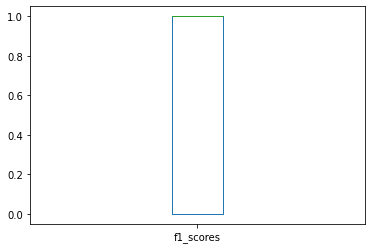

In [16]:
from scipy.stats import sem
_ = tsd_test.f1_scores.plot(kind="box")
print (f"F1 = {tsd_test.f1_scores.mean():.2f} ± {sem(tsd_test.f1_scores):.2f}")

In [17]:
# make sure that the ids match the ones of the scores
predictions = tsd_test.predicted_spans.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-pred.txt

0	[140, 141, 142, 143, 144, 145, 146]
1	[54, 55, 56, 57, 59, 60, 61, 62, 64, 65, 66, 67, 81, 82, 83, 84, 85, 86]
2	[483, 484, 485, 486, 487, 488, 489, 490]
3	[413, 414, 415, 416, 417, 418, 419, 420]
4	[311, 312, 313, 314, 315, 316, 317, 391, 392, 393, 394, 395, 396, 397]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62]
8	[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, 205, 206, 207, 208, 321, 322, 323, 324, 325, 326]
9	[94, 95, 96, 97]


In [18]:
gold = tsd_test.spans.to_list()
ids = tsd_test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-gold.txt", "w") as out:
  for uid, text_scores in zip(ids, gold):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-gold.txt

0	[84, 85, 86, 87, 88, 89, 90, 91, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
1	[81, 82, 83, 84, 85, 86]
2	[]
3	[]
4	[]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
8	[37, 38, 39, 40, 41, 158, 159, 160, 161, 204, 205, 206, 207, 208]
9	[94, 95, 96, 97]


In [19]:
predictions = open("gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-pred.txt", "r")
gold = open("gdrive/MyDrive/CSI4900-Project/Naive_Bayes/spans-gold.txt", "r")

score = evaluate(predictions, gold)
print(score)

(0.6386467507349544, 0.009668266798475642)
